# Find precipitation value for pulsed and upslope storms

In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')

import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')



In [2]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

In [3]:
savefig = 1
if savefig == 1:
    figdir = '../../Figures/Weathermast_MEPS/%s/precip_seasonal_stat' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

### Minuelty data

In [4]:
obs_f = dict()
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m   = dict()
obs_wind_speed_10m = dict()
obs_dofe_acc   = dict()
obs_wind_dir   = dict()
obs_wind_speed = dict() 
obs_dofe_acc_rolling = dict()
obs_wind_dir_rolling = dict()
obs_wind_speed_rolling = dict()
obs_diff = dict()
obs_westerly_idx = dict()
obs_easterly_idx = dict()
obs_westerly = dict()
obs_easterly = dict()
obs_total_precip = dict()
obs_precip_west  = dict()
obs_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        obs_dirnc = '../../Data/Weathermast/Met_%s%s%s_%s.nc' %(year,month,day,station)
        obs_f[int(year+month+day)] = netCDF4.Dataset(obs_dirnc, 'r')

        obs_double_fence_acc_mean[int(year+month+day)] = (np.nanmean(obs_f[int(year+month+day)].variables['double_fence_accum'][:], axis=1))
        obs_wind_dir_10m[int(year+month+day)]   = (obs_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
        obs_wind_speed_10m[int(year+month+day)] = (obs_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        obs_f[int(year+month+day)].close
        
        ## Create a rolling mean to smoothen out the data
        # attach the last 9 minutes from the previous day to calculate the rolling mean every 10 minutes
        if month != '11' and day == '01':
            if month == '12':
                previous_day = '30'
            elif month == '01' or month == '02':
                previous_day = '31'
            elif month == '03':
                previous_day = '28'
            if month == '01':
                previous_month = '12'
                previous_year = str(int(year)-1)
            elif month == '12':
                previous_month = str(int(month)-1)
                previous_year = year
            else:
                previous_month = '0%s' %(int(month)-1)
                previous_year = year
            
        elif int(day)-1 < 10:
            previous_day = '0%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        else:
            previous_day = '%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        if year == '2016' and month == '11' and day == '07':
            continue
        else:
            pp = (np.concatenate((obs_double_fence_acc_mean[int(previous_year+previous_month+previous_day)][-9:],
                                  obs_double_fence_acc_mean[int(year+month+day)][:])))
            obs_dofe_acc[int(year+month+day)] = (pp)
            wd = (np.concatenate((obs_wind_dir_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_dir_10m[int(year+month+day)][:])))
            obs_wind_dir[int(year+month+day)] = (wd)
            ws = (np.concatenate((obs_wind_speed_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_speed_10m[int(year+month+day)][:])))
            obs_wind_speed[int(year+month+day)] = (ws)
        # Calculate the moving average. That is, take
        # the first ten values, average them, 
        # then drop the first and add the eleventh, etc.
        obs_dofe_acc[int(year+month+day)] = pd.DataFrame(np.array(obs_dofe_acc[int(year+month+day)])[:])
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc[int(year+month+day)].rolling(window=10,
                                                                                              min_periods= 7,
                                                                                              axis=0).mean()
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc_rolling[int(year+month+day)].values
        obs_dofe_acc_rolling[int(year+month+day)] = np.array(obs_dofe_acc_rolling[int(year+month+day)])[9:,:]

        obs_wind_dir[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_dir[int(year+month+day)])[:])
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir[int(year+month+day)].rolling(window=10,
                                                                                              min_periods=7,
                                                                                              axis=0).mean()
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir_rolling[int(year+month+day)].values
        obs_wind_dir_rolling[int(year+month+day)] = np.array(obs_wind_dir_rolling[int(year+month+day)])[9:,:]

        obs_wind_speed[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_speed[int(year+month+day)])[:])
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed[int(year+month+day)].rolling(window=10,
                                                                                                  min_periods=7,
                                                                                                  axis=0).mean()
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed_rolling[int(year+month+day)].values
        obs_wind_speed_rolling[int(year+month+day)] = np.array(obs_wind_speed_rolling[int(year+month+day)])[9:,:]
        
        
        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[int(year+month+day)] = np.empty(shape=(obs_dofe_acc_rolling[int(year+month+day)].shape))#/60))
        obs_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,obs_dofe_acc_rolling[int(year+month+day)].shape[0]-1):#/60):
            obs_diff[int(year+month+day)][int(i),:] = obs_dofe_acc_rolling[int(year+month+day)][int(i)+1] - \
                                                      obs_dofe_acc_rolling[int(year+month+day)][int(i)]


        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg) 
        obs_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 202.5), 
                                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <= 360)),
                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <22.5))]
        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 22.5),
                                                                (obs_wind_dir_rolling[int(year+month+day)][:,0] < 202.5))]

        ## find indices for all obs_westerly regimes 
        sub_idx = []

        for i in range(0,obs_westerly_idx[int(year+month+day)] .shape[0]-1):
            if obs_westerly_idx[int(year+month+day)] [i]+1 == obs_westerly_idx[int(year+month+day)] [i+1]:
                continue
            else:
                #print(i)
                sub_idx.append(i)
    
    #        print([int(year+month+day)], obs_westerly_idx[int(year+month+day)], sub_idx)
        
        
        ## find westerlies which are < 29 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx[int(year+month+day)]) == 0 and len(sub_idx) == 0:     # westerlies do not exist
            obs_westerly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
#            print('No obs_westerly wind on %s' %(int(year+month+day)))
        elif len(obs_westerly_idx[int(year+month+day)]) != 0 and len(sub_idx) == 0:   # westerlies exist only for one time period a day
            obs_westerly[int(year+month+day)] = []
      #      obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
            
            obs_westerly_duration = obs_westerly_idx[int(year+month+day)][-1] - obs_westerly_idx[int(year+month+day)][0]
            if obs_westerly_duration >= 28:
                obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
            elif obs_westerly_duration < 28:
                obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
        else:
            obs_westerly[int(year+month+day)] = []
         #   obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]

            for i in np.arange(0,np.array(sub_idx).shape[0]+1):                # westerlies and easterlies interchange daily
                if i == 0:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[0]] - \
                                         obs_westerly_idx[int(year+month+day)] [0])
                elif i == np.array(sub_idx).shape[0]:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [-1] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1])
                else:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[i]] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1])
                if obs_westerly_duration >= 28:
                    if i == 0:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
            #            print(obs_westerly_duration, RR_obs_westerly)
                    elif i == np.array(sub_idx).shape[0]:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
             #           print(obs_westerly_duration, RR_obs_westerly)
                    else:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
              #          print(obs_westerly_duration, RR_obs_westerly)
                elif obs_westerly_duration < 28:
                    if i == 0:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
                    elif i == np.array(sub_idx).shape[0]:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
                    else:
                   # print(obs_westerly_duration)
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
        

        if len(obs_westerly[int(year+month+day)]) == 0:    # only easterlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(len(obs_westerly[int(year+month+day)]),2))
        elif len(obs_easterly[int(year+month+day)]) == 0:  # only westerlies
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(len(obs_easterly[int(year+month+day)]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
        else:    # both easterlies and westerlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)
            
            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
            
        # assign sum values to days
        obs_total_precip[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                                                np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:])
        obs_precip_east[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:])
        obs_precip_west[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:])

[20161108] total precipitation [mm/24h]: -0.01 obs_easterly [mm/24h]: -0.01 obs_westerly [mm/24h]: 0
[20161109] total precipitation [mm/24h]: 0.31 obs_easterly [mm/24h]: 0.31 obs_westerly [mm/24h]: 0
[20161110] total precipitation [mm/24h]: 0.12 obs_easterly [mm/24h]: 0.03 obs_westerly [mm/24h]: 0.09
[20161111] total precipitation [mm/24h]: -0.03 obs_easterly [mm/24h]: 0.14 obs_westerly [mm/24h]: -0.17
[20161112] total precipitation [mm/24h]: 3.45 obs_easterly [mm/24h]: 3.45 obs_westerly [mm/24h]: 0
[20161113] total precipitation [mm/24h]: 1.47 obs_easterly [mm/24h]: 1.11 obs_westerly [mm/24h]: 0.36
[20161114] total precipitation [mm/24h]: 3.43 obs_easterly [mm/24h]: 2.22 obs_westerly [mm/24h]: 1.21
[20161115] total precipitation [mm/24h]: 4.44 obs_easterly [mm/24h]: 2.38 obs_westerly [mm/24h]: 2.06
[20161116] total precipitation [mm/24h]: 14.58 obs_easterly [mm/24h]: 5.91 obs_westerly [mm/24h]: 8.67
[20161117] total precipitation [mm/24h]: 9.0 obs_easterly [mm/24h]: 1.58 obs_westerly 

[20170131] total precipitation [mm/24h]: -1.16 obs_easterly [mm/24h]: -0.8 obs_westerly [mm/24h]: -0.35
[20170201] total precipitation [mm/24h]: -0.61 obs_easterly [mm/24h]: -0.48 obs_westerly [mm/24h]: -0.13
[20170202] total precipitation [mm/24h]: 5.82 obs_easterly [mm/24h]: 5.82 obs_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: 6.48 obs_easterly [mm/24h]: 6.15 obs_westerly [mm/24h]: 0.33
[20170204] total precipitation [mm/24h]: 2.82 obs_easterly [mm/24h]: 2.78 obs_westerly [mm/24h]: 0.04
[20170205] total precipitation [mm/24h]: 1.13 obs_easterly [mm/24h]: 1.11 obs_westerly [mm/24h]: 0.02
[20170206] total precipitation [mm/24h]: 0.0 obs_easterly [mm/24h]: 0.0 obs_westerly [mm/24h]: 0
[20170207] total precipitation [mm/24h]: 0.0 obs_easterly [mm/24h]: 0.0 obs_westerly [mm/24h]: 0
[20170208] total precipitation [mm/24h]: 0.0 obs_easterly [mm/24h]: 0.0 obs_westerly [mm/24h]: 0
[20170209] total precipitation [mm/24h]: -0.04 obs_easterly [mm/24h]: -0.04 obs_westerly [mm/24

### Eklima data

In [5]:
eklima_f = dict()
eklima_double_fence_acc = dict()
eklima_wind_dir_10m   = dict()
eklima_wind_speed_10m = dict()
eklima_diff = dict()
eklima_westerly_idx = dict()
eklima_easterly_idx = dict()
eklima_westerly = dict()
eklima_easterly = dict()
eklima_total_precip = dict()
eklima_precip_west  = dict()
eklima_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        eklima_dirnc = '../../Data/Eklima/%s/precip_wind_temp_%s%s%s.nc' %(station,year,month,day)
        eklima_f[int(year+month+day)] = netCDF4.Dataset(eklima_dirnc, 'r')

        eklima_double_fence_acc[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['RR_1'][:])
        eklima_wind_dir_10m[int(year+month+day)]   = (eklima_f[int(year+month+day)].variables['DD'][:])
        eklima_wind_speed_10m[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['FF'][:])
        
        eklima_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        eklima_diff[int(year+month+day)] = np.empty(shape=(eklima_double_fence_acc[int(year+month+day)].shape))#/60))
        eklima_diff[int(year+month+day)][:] =  np.nan

        eklima_diff[int(year+month+day)][:,] = eklima_double_fence_acc[int(year+month+day)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(eklima_wind_dir_10m[int(year+month+day)].shape[0])

        ## find all eklima_westerly regimes (202.5 - 22.5 deg) 
        eklima_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 202.5),
                                                                                     (eklima_wind_dir_10m[int(year+month+day)][:,] <= 360)),
                                                                      (eklima_wind_dir_10m[int(year+month+day)][:,] <22.5))]

        ## find all eklima_easterly regimes (22.5 - 202.5 deg)
        eklima_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 22.5),
                                                                       (eklima_wind_dir_10m[int(year+month+day)][:,] < 202.5))]

        eklima_westerly[int(year+month+day)] = eklima_westerly_idx[int(year+month+day)]
        eklima_easterly[int(year+month+day)] = eklima_easterly_idx[int(year+month+day)]

        if len(eklima_westerly[int(year+month+day)]) == 0:    # only easterlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(len(eklima_westerly[int(year+month+day)]),2))

        elif len(eklima_easterly[int(year+month+day)]) == 0:  # only westerlies
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(len(eklima_easterly[int(year+month+day)]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))
        else:    # both easterlies and westerlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)
            
            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))

        # assign sum values to days
        eklima_total_precip[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],])
        eklima_precip_east[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],])
        eklima_precip_west[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],])
        

        if obs_total_precip[int(year+month+day)] < 0:
            if obs_precip_east[int(year+month+day)] < 0 and obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
    
            elif obs_precip_east[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
        
            elif obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
        
        elif obs_precip_east[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])   
    
        elif obs_precip_west[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
    

[20161108] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161109] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161110] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161111] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161112] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161113] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161114] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161115] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161116] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161117] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.

[20170127] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: 1.6 eklima_easterly [mm/24h]: 1.0 eklima_westerly [mm/24h]: 0.6
[20170129] total precipitation [mm/24h]: 23.7 eklima_easterly [mm/24h]: 17.7 eklima_westerly [mm/24h]: 6.0
[20170130] total precipitation [mm/24h]: 0.2 eklima_easterly [mm/24h]: 0 eklima_westerly [mm/24h]: 0.2
[20170131] total precipitation [mm/24h]: 0.9 eklima_easterly [mm/24h]: 0.2 eklima_westerly [mm/24h]: 0.7
[20170201] total precipitation [mm/24h]: 0.3 eklima_easterly [mm/24h]: 0.3 eklima_westerly [mm/24h]: 0.0
[20170202] total precipitation [mm/24h]: 6.3 eklima_easterly [mm/24h]: 6.3 eklima_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: 6.9 eklima_easterly [mm/24h]: 5.7 eklima_westerly [mm/24h]: 1.2
[20170204] total precipitation [mm/24h]: 3.1 eklima_easterly [mm/24h]: 3.1 eklima_westerly [mm/24h]: 0.0
[20170205] total precipitation [mm/24h]: 2.2 eklima_easte

### MEPS data

In [6]:
def fill_values(variable):
    if np.ma.is_masked(variable):
        mask = np.ma.getmaskarray(variable[:,:,:])
        marr = np.ma.array(variable[:,:,:], mask = mask, fill_value = np.nan)
        filled = marr.filled(np.nan)
        
    else:
        filled = variable[:]
        
    return(filled)

In [7]:
meps_f = dict()
meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_diff = dict()
meps_wind_dir   = dict()
meps_wind_speed = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()
meps_westerly = dict()
meps_easterly = dict()
meps_total_precip = dict()
meps_precip_west  = dict()
meps_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        meps_dirnc = '../../Data/MEPS/%s/%s%s/sfc_hybrid5_allEM_00/%s%s%s_00.nc' %(station,year,month,year,month,day)
        try:
            meps_f[int(year+month+day)] = netCDF4.Dataset(meps_dirnc, 'r')
        except OSError:
            print('no file found: %s' %meps_dirnc)
#            meps_precip_acc[int(year+month+day)] = np.empty(shape=(67, 1, 10))
 #           meps_xwind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
  #          meps_ywind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
            
            meps_total_precip[int(year+month+day)] = np.empty(shape=(10, ))
            meps_total_precip[int(year+month+day)][:] = np.nan
            meps_precip_east[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_east[int(year+month+day)][:] = np.nan
            meps_precip_west[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_west[int(year+month+day)][:] = np.nan
            continue

        meps_precip_acc[int(year+month+day)] = (meps_f[int(year+month+day)].variables['precipitation_amount_acc'][:])
        meps_xwind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['x_wind_10m'][:])
        meps_ywind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['y_wind_10m'][:])
        
        ## substitute missing values with nan
        meps_precip_acc[int(year+month+day)] = fill_values(meps_precip_acc[int(year+month+day)][:,:,:])
        meps_xwind_10m[int(year+month+day)] = fill_values(meps_xwind_10m[int(year+month+day)][:,:,:])
        meps_ywind_10m[int(year+month+day)] = fill_values(meps_ywind_10m[int(year+month+day)][:,:,:])
        
#        meps_wind_dir_10m[int(year+month+day)]   = (meps_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
#        meps_wind_speed_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        meps_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        meps_diff[int(year+month+day)] = np.empty(shape=(meps_precip_acc[int(year+month+day)].shape))#/60))
        meps_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,meps_precip_acc[int(year+month+day)].shape[0]-1):
            meps_diff[int(year+month+day)][int(i),:,:] = meps_precip_acc[int(year+month+day)][int(i)+1,:,:] - \
                                                         meps_precip_acc[int(year+month+day)][int(i),:,:]

        #### calculate wind direction / speed
        meps_wind_dir[int(year+month+day)] = np.arctan2(meps_ywind_10m[int(year+month+day)][:,:,:], 
                                                        meps_xwind_10m[int(year+month+day)][:,:,:]) 
        meps_wind_dir[int(year+month+day)] = 270 - np.rad2deg(meps_wind_dir[int(year+month+day)])
        larger360 = np.where(meps_wind_dir[int(year+month+day)][:,:,:] > 360.)
        meps_wind_dir[int(year+month+day)][larger360] = meps_wind_dir[int(year+month+day)][larger360]-360
    
        meps_wind_speed[int(year+month+day)] = np.sqrt((meps_xwind_10m[int(year+month+day)][:,:,:])**2 + \
                                                           (meps_ywind_10m[int(year+month+day)][:,:,:])**2 )
        
        ### only get values up to 24h
        meps_diff[int(year+month+day)] = meps_diff[int(year+month+day)][:25,:,:]
        meps_wind_dir[int(year+month+day)] = meps_wind_dir[int(year+month+day)][:25,:,:]
        meps_wind_speed[int(year+month+day)] = meps_wind_speed[int(year+month+day)][:25,:,:]

        # Find wind regimes and associated precip amount
        IDX = np.arange(meps_wind_dir[int(year+month+day)].shape[0])

        meps_westerly_idx[int(year+month+day)] = []
        meps_easterly_idx[int(year+month+day)] = []

        for ens_memb in range(10):
            ## find all meps_westerly regimes (202.5 - 22.5 deg) 
            meps_westerly_idx[int(year+month+day)].append(IDX[np.logical_or(
                    np.logical_and((meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 202.5), 
                                   (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <= 360)),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5))])
#        print(np.array(meps_westerly_idx[int(year+month+day)][ens_memb]).shape)


            ## find all meps_easterly regimes (22.5 - 202.5 deg)
            meps_easterly_idx[int(year+month+day)].append(IDX[np.logical_and(
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 22.5),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 202.5))])
#        print(np.array(meps_easterly_idx[int(year+month+day)][ens_memb]).shape)

        
        meps_westerly[int(year+month+day)] = meps_westerly_idx[int(year+month+day)]
        meps_easterly[int(year+month+day)] = meps_easterly_idx[int(year+month+day)]
        
        meps_easterly_idx[int(year+month+day)] = np.array(meps_easterly_idx[int(year+month+day)])
        meps_westerly_idx[int(year+month+day)] = np.array(meps_westerly_idx[int(year+month+day)])

        meps_total_precip[int(year+month+day)] = []
        meps_precip_east[int(year+month+day)] = []
        meps_precip_west[int(year+month+day)] = []

        for ens_memb in range(10):
            if len(meps_westerly[int(year+month+day)][ens_memb]) == 0:    # only easterlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(len(meps_westerly[int(year+month+day)][ens_memb]),2))

            elif len(meps_easterly[int(year+month+day)][ens_memb]) == 0:  # only westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(len(meps_easterly[int(year+month+day)][ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))

            else:    # both easterlies and westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))
            

            # assign sum values to days
            total = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                    np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_total_precip[int(year+month+day)].append(total)
    
            easterly = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_east[int(year+month+day)].append(easterly)
    
            westerly = np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_west[int(year+month+day)].append(westerly)

[20161108] total precipitation [mm/24h]: EM=0 0.58 meps_easterly [mm/24h]: 0.58 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=1 0.66 meps_easterly [mm/24h]: 0.66 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=2 0.51 meps_easterly [mm/24h]: 0.51 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=3 0.38 meps_easterly [mm/24h]: 0.38 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=4 0.76 meps_easterly [mm/24h]: 0.76 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=5 0.61 meps_easterly [mm/24h]: 0.61 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=6 0.46 meps_easterly [mm/24h]: 0.46 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=7 0.61 meps_easterly [mm/24h]: 0.61 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=8 0.66 meps_easterly [mm/24h]: 0.66 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]:

[20161117] total precipitation [mm/24h]: EM=0 7.74 meps_easterly [mm/24h]: 3.18 meps_westerly [mm/24h]: 4.56
[20161117] total precipitation [mm/24h]: EM=1 9.28 meps_easterly [mm/24h]: 2.81 meps_westerly [mm/24h]: 6.47
[20161117] total precipitation [mm/24h]: EM=2 17.52 meps_easterly [mm/24h]: 4.32 meps_westerly [mm/24h]: 13.2
[20161117] total precipitation [mm/24h]: EM=3 19.65 meps_easterly [mm/24h]: 5.85 meps_westerly [mm/24h]: 13.81
[20161117] total precipitation [mm/24h]: EM=4 8.13 meps_easterly [mm/24h]: 0.72 meps_westerly [mm/24h]: 7.41
[20161117] total precipitation [mm/24h]: EM=5 21.94 meps_easterly [mm/24h]: 5.02 meps_westerly [mm/24h]: 16.92
[20161117] total precipitation [mm/24h]: EM=6 11.42 meps_easterly [mm/24h]: 2.71 meps_westerly [mm/24h]: 8.71
[20161117] total precipitation [mm/24h]: EM=7 10.42 meps_easterly [mm/24h]: 2.68 meps_westerly [mm/24h]: 7.74
[20161117] total precipitation [mm/24h]: EM=8 10.92 meps_easterly [mm/24h]: 3.29 meps_westerly [mm/24h]: 7.62
[20161117] 

[20161125] total precipitation [mm/24h]: EM=0 5.88 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 5.88
[20161125] total precipitation [mm/24h]: EM=1 6.32 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 6.32
[20161125] total precipitation [mm/24h]: EM=2 5.49 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 5.49
[20161125] total precipitation [mm/24h]: EM=3 5.25 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 5.25
[20161125] total precipitation [mm/24h]: EM=4 7.93 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 7.93
[20161125] total precipitation [mm/24h]: EM=5 6.12 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 6.12
[20161125] total precipitation [mm/24h]: EM=6 6.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 6.01
[20161125] total precipitation [mm/24h]: EM=7 7.1 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 7.1
[20161125] total precipitation [mm/24h]: EM=8 4.81 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 4.81
[20161125] total precipitation [mm/24h]: EM=9 7.

[20161203] total precipitation [mm/24h]: EM=0 0.94 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.94
[20161203] total precipitation [mm/24h]: EM=1 0.54 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.54
[20161203] total precipitation [mm/24h]: EM=2 1.2 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.2
[20161203] total precipitation [mm/24h]: EM=3 0.45 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.45
[20161203] total precipitation [mm/24h]: EM=4 0.67 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.67
[20161203] total precipitation [mm/24h]: EM=5 1.22 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.22
[20161203] total precipitation [mm/24h]: EM=6 0.56 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.56
[20161203] total precipitation [mm/24h]: EM=7 1.26 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.26
[20161203] total precipitation [mm/24h]: EM=8 0.69 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.69
[20161203] total precipitation [mm/24h]: EM=9 0.

[20161212] total precipitation [mm/24h]: EM=0 0.49 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.49
[20161212] total precipitation [mm/24h]: EM=1 0.46 meps_easterly [mm/24h]: 0.01 meps_westerly [mm/24h]: 0.45
[20161212] total precipitation [mm/24h]: EM=2 0.21 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.21
[20161212] total precipitation [mm/24h]: EM=3 0.17 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.17
[20161212] total precipitation [mm/24h]: EM=4 0.85 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.85
[20161212] total precipitation [mm/24h]: EM=5 0.46 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.46
[20161212] total precipitation [mm/24h]: EM=6 0.53 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.53
[20161212] total precipitation [mm/24h]: EM=7 0.23 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.23
[20161212] total precipitation [mm/24h]: EM=8 0.48 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.48
[20161212] total precipitat

[20161222] total precipitation [mm/24h]: EM=0 38.97 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 38.97
[20161222] total precipitation [mm/24h]: EM=1 34.49 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 34.49
[20161222] total precipitation [mm/24h]: EM=2 22.13 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 22.13
[20161222] total precipitation [mm/24h]: EM=3 34.55 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 34.55
[20161222] total precipitation [mm/24h]: EM=4 29.22 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 29.22
[20161222] total precipitation [mm/24h]: EM=5 37.96 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 37.96
[20161222] total precipitation [mm/24h]: EM=6 30.19 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 30.19
[20161222] total precipitation [mm/24h]: EM=7 33.56 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 33.56
[20161222] total precipitation [mm/24h]: EM=8 34.71 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 34.71
[20161222] total precipitati

[20170102] total precipitation [mm/24h]: EM=0 1.9 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.9
[20170102] total precipitation [mm/24h]: EM=1 1.44 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.44
[20170102] total precipitation [mm/24h]: EM=2 1.37 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.37
[20170102] total precipitation [mm/24h]: EM=3 1.79 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.79
[20170102] total precipitation [mm/24h]: EM=4 2.71 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.71
[20170102] total precipitation [mm/24h]: EM=5 1.47 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.47
[20170102] total precipitation [mm/24h]: EM=6 2.12 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.12
[20170102] total precipitation [mm/24h]: EM=7 0.93 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.93
[20170102] total precipitation [mm/24h]: EM=8 2.52 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.52
[20170102] total precipitation [mm/24h]: EM=9 1.

[20170110] total precipitation [mm/24h]: EM=0 11.5 meps_easterly [mm/24h]: 6.82 meps_westerly [mm/24h]: 4.68
[20170110] total precipitation [mm/24h]: EM=1 13.15 meps_easterly [mm/24h]: 5.93 meps_westerly [mm/24h]: 7.23
[20170110] total precipitation [mm/24h]: EM=2 9.79 meps_easterly [mm/24h]: 5.23 meps_westerly [mm/24h]: 4.55
[20170110] total precipitation [mm/24h]: EM=3 5.17 meps_easterly [mm/24h]: 3.63 meps_westerly [mm/24h]: 1.54
[20170110] total precipitation [mm/24h]: EM=4 17.85 meps_easterly [mm/24h]: 8.76 meps_westerly [mm/24h]: 9.1
[20170110] total precipitation [mm/24h]: EM=5 11.59 meps_easterly [mm/24h]: 6.77 meps_westerly [mm/24h]: 4.82
[20170110] total precipitation [mm/24h]: EM=6 14.43 meps_easterly [mm/24h]: 9.87 meps_westerly [mm/24h]: 4.56
[20170110] total precipitation [mm/24h]: EM=7 11.07 meps_easterly [mm/24h]: 4.19 meps_westerly [mm/24h]: 6.87
[20170110] total precipitation [mm/24h]: EM=8 11.18 meps_easterly [mm/24h]: 5.94 meps_westerly [mm/24h]: 5.24
[20170110] tot

[20170118] total precipitation [mm/24h]: EM=0 2.5 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.5
[20170118] total precipitation [mm/24h]: EM=1 1.5 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.5
[20170118] total precipitation [mm/24h]: EM=2 2.37 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.37
[20170118] total precipitation [mm/24h]: EM=3 1.48 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.48
[20170118] total precipitation [mm/24h]: EM=4 3.93 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.93
[20170118] total precipitation [mm/24h]: EM=5 1.79 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.79
[20170118] total precipitation [mm/24h]: EM=6 2.16 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.16
[20170118] total precipitation [mm/24h]: EM=7 2.3 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.3
[20170118] total precipitation [mm/24h]: EM=8 1.34 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.34
[20170118] total precipitation [mm/24h]: EM=9 1.72 m

[20170126] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=5 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170126] total precipitation [mm/24h]:

[20170203] total precipitation [mm/24h]: EM=0 5.83 meps_easterly [mm/24h]: 5.83 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=1 3.92 meps_easterly [mm/24h]: 3.92 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=2 3.39 meps_easterly [mm/24h]: 3.39 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=3 4.89 meps_easterly [mm/24h]: 4.89 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=4 4.88 meps_easterly [mm/24h]: 4.88 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=5 2.98 meps_easterly [mm/24h]: 2.98 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=6 6.63 meps_easterly [mm/24h]: 6.63 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=7 6.84 meps_easterly [mm/24h]: 6.84 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=8 3.0 meps_easterly [mm/24h]: 3.0 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=9 5.

[20170211] total precipitation [mm/24h]: EM=0 0.99 meps_easterly [mm/24h]: 0.99 meps_westerly [mm/24h]: -0.0
[20170211] total precipitation [mm/24h]: EM=1 0.84 meps_easterly [mm/24h]: 0.84 meps_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: EM=2 0.97 meps_easterly [mm/24h]: 0.97 meps_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: EM=3 0.5 meps_easterly [mm/24h]: 0.5 meps_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: EM=4 1.34 meps_easterly [mm/24h]: 1.3 meps_westerly [mm/24h]: 0.04
[20170211] total precipitation [mm/24h]: EM=5 0.85 meps_easterly [mm/24h]: 0.85 meps_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: EM=6 0.78 meps_easterly [mm/24h]: 0.71 meps_westerly [mm/24h]: 0.07
[20170211] total precipitation [mm/24h]: EM=7 0.87 meps_easterly [mm/24h]: 0.87 meps_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: EM=8 0.87 meps_easterly [mm/24h]: 0.87 meps_westerly [mm/24h]: 0.0
[20170211] total precipitati

[20170219] total precipitation [mm/24h]: EM=0 3.71 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.71
[20170219] total precipitation [mm/24h]: EM=1 2.16 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 2.16
[20170219] total precipitation [mm/24h]: EM=2 4.88 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 4.88
[20170219] total precipitation [mm/24h]: EM=3 4.27 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 4.27
[20170219] total precipitation [mm/24h]: EM=4 3.73 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.73
[20170219] total precipitation [mm/24h]: EM=5 3.78 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.78
[20170219] total precipitation [mm/24h]: EM=6 3.19 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.19
[20170219] total precipitation [mm/24h]: EM=7 3.79 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.79
[20170219] total precipitation [mm/24h]: EM=8 3.2 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 3.2
[20170219] total precipitation [mm/24h]: EM=9 4.

[20170227] total precipitation [mm/24h]: EM=0 11.77 meps_easterly [mm/24h]: 11.59 meps_westerly [mm/24h]: 0.18
[20170227] total precipitation [mm/24h]: EM=1 4.21 meps_easterly [mm/24h]: 4.04 meps_westerly [mm/24h]: 0.17
[20170227] total precipitation [mm/24h]: EM=2 14.1 meps_easterly [mm/24h]: 13.83 meps_westerly [mm/24h]: 0.27
[20170227] total precipitation [mm/24h]: EM=3 10.9 meps_easterly [mm/24h]: 10.6 meps_westerly [mm/24h]: 0.3
[20170227] total precipitation [mm/24h]: EM=4 14.93 meps_easterly [mm/24h]: 14.82 meps_westerly [mm/24h]: 0.11
[20170227] total precipitation [mm/24h]: EM=5 8.9 meps_easterly [mm/24h]: 8.66 meps_westerly [mm/24h]: 0.24
[20170227] total precipitation [mm/24h]: EM=6 8.13 meps_easterly [mm/24h]: 8.06 meps_westerly [mm/24h]: 0.07
[20170227] total precipitation [mm/24h]: EM=7 5.43 meps_easterly [mm/24h]: 5.19 meps_westerly [mm/24h]: 0.24
[20170227] total precipitation [mm/24h]: EM=8 14.39 meps_easterly [mm/24h]: 14.29 meps_westerly [mm/24h]: 0.09
[20170227] tot

[20170307] total precipitation [mm/24h]: EM=8 0.02 meps_easterly [mm/24h]: 0.02 meps_westerly [mm/24h]: 0.0
[20170307] total precipitation [mm/24h]: EM=9 0.1 meps_easterly [mm/24h]: 0.1 meps_westerly [mm/24h]: 0.0
[20170308] total precipitation [mm/24h]: EM=0 8.63 meps_easterly [mm/24h]: 6.96 meps_westerly [mm/24h]: 1.67
[20170308] total precipitation [mm/24h]: EM=1 14.08 meps_easterly [mm/24h]: 13.38 meps_westerly [mm/24h]: 0.71
[20170308] total precipitation [mm/24h]: EM=2 5.79 meps_easterly [mm/24h]: 5.79 meps_westerly [mm/24h]: 0.0
[20170308] total precipitation [mm/24h]: EM=3 6.83 meps_easterly [mm/24h]: 6.83 meps_westerly [mm/24h]: 0.0
[20170308] total precipitation [mm/24h]: EM=4 4.91 meps_easterly [mm/24h]: 4.88 meps_westerly [mm/24h]: 0.03
[20170308] total precipitation [mm/24h]: EM=5 2.16 meps_easterly [mm/24h]: 1.72 meps_westerly [mm/24h]: 0.44
[20170308] total precipitation [mm/24h]: EM=6 13.64 meps_easterly [mm/24h]: 13.5 meps_westerly [mm/24h]: 0.14
[20170308] total preci

[20170316] total precipitation [mm/24h]: EM=0 14.27 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.27
[20170316] total precipitation [mm/24h]: EM=1 13.86 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 13.86
[20170316] total precipitation [mm/24h]: EM=2 13.03 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 13.03
[20170316] total precipitation [mm/24h]: EM=3 12.32 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.32
[20170316] total precipitation [mm/24h]: EM=4 12.51 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.51
[20170316] total precipitation [mm/24h]: EM=5 11.29 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 11.29
[20170316] total precipitation [mm/24h]: EM=6 14.95 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.95
[20170316] total precipitation [mm/24h]: EM=7 15.54 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 15.54
[20170316] total precipitation [mm/24h]: EM=8 12.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.0
[20170316] total precipitation

[20170325] total precipitation [mm/24h]: EM=0 0.14 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.14
[20170325] total precipitation [mm/24h]: EM=1 0.15 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.15
[20170325] total precipitation [mm/24h]: EM=2 0.14 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.14
[20170325] total precipitation [mm/24h]: EM=3 0.26 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.26
[20170325] total precipitation [mm/24h]: EM=4 0.04 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.04
[20170325] total precipitation [mm/24h]: EM=5 0.11 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.11
[20170325] total precipitation [mm/24h]: EM=6 0.26 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.26
[20170325] total precipitation [mm/24h]: EM=7 0.26 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.26
[20170325] total precipitation [mm/24h]: EM=8 0.11 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.11
[20170325] total precipitation [mm/24h]: EM=9 

In [8]:
print('total', sum(obs_total_precip.values()) ,
      'east', sum(obs_precip_east.values()),
      'west', sum(obs_precip_west.values()) )

total 513.3785000000498 east 174.6437037037354 west 338.73479629631436


In [9]:
# calculate monthly precip sum
obs_total = []
obs_total_east = []
obs_total_west = []
for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    obs_monthly_sum = 0.0
    obs_monthly_east_sum = 0.0
    obs_monthly_west_sum = 0.0
    
    

    for day in t:
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
        tot_val = (obs_total_precip[int(year+month+day)])
        obs_monthly_sum = np.sum([obs_monthly_sum,tot_val])
        
        east_val = (obs_precip_east[int(year+month+day)])
        obs_monthly_east_sum = np.sum([obs_monthly_east_sum, east_val])
        
        west_val = (obs_precip_west[int(year+month+day)])
        obs_monthly_west_sum = np.sum([obs_monthly_west_sum, west_val])
        
        if int(day) == t[-1]:
            obs_total.append(obs_monthly_sum)
            obs_total_east.append(obs_monthly_east_sum)
            obs_total_west.append(obs_monthly_west_sum)
            
    print(int(year+month+day), 'total:', np.round(obs_monthly_sum,2),
                               'east:',  np.round(obs_monthly_east_sum,2),
                               'west:',  np.round(obs_monthly_west_sum),2)
print('total:', np.round(sum(obs_total_precip.values()),2), 
      'east:', np.round(sum(obs_precip_east.values()),2), 
      'west:', np.round(sum(obs_precip_west.values()),2))

20161130 total: 51.8 east: 23.59 west: 28.0 2
20161231 total: 209.98 east: 24.05 west: 186.0 2
20170131 total: 94.24 east: 38.89 west: 55.0 2
20170228 total: 84.69 east: 47.2 west: 37.0 2
20170331 total: 72.67 east: 40.92 west: 32.0 2
total: 513.38 east: 174.64 west: 338.73


In [10]:
meps_sum = 0.0
meps_east_sum = 0.0
meps_west_sum = 0.0
meps_total = []
meps_total_east = []
meps_total_west = []

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for ens_memb in np.arange(0,10):
        meps_monthly_sum = 0.0
        meps_monthly_east_sum = 0.0
        meps_monthly_west_sum = 0.0
        
        
        
        for day in t:
            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day
        
            tot_val = meps_total_precip[int(year+month+day)][ens_memb]
            meps_monthly_sum = np.nansum([meps_monthly_sum, tot_val])
        
            east_val = meps_precip_east[int(year+month+day)][ens_memb]
            meps_monthly_east_sum = np.nansum([meps_monthly_east_sum, east_val])
        
            west_val = meps_precip_west[int(year+month+day)][ens_memb]
            meps_monthly_west_sum = np.nansum([meps_monthly_west_sum, west_val])
        
            if int(day) == t[-1]:
                meps_total.append(meps_monthly_sum)
                meps_total_east.append(meps_monthly_east_sum)
                meps_total_west.append(meps_monthly_west_sum)

        print(int(year+month+day), 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_monthly_sum,2),
                               'east:',  np.round(meps_monthly_east_sum,2),
                               'west:',  np.round(meps_monthly_west_sum,2))
        




meps_total = (np.reshape(meps_total, (5,10)))
meps_total_east = (np.reshape(meps_total_east, (5,10)))
meps_total_west = (np.reshape(meps_total_west, (5,10)))

meps_sum = np.sum(meps_total[:,:],axis=0)
meps_east_sum = np.sum(meps_total_east[:,:], axis=0)
meps_west_sum = np.sum(meps_total_west[:,:], axis=0)

for ens_memb in range(10):
    print('total:', 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_sum[ens_memb],2),
                               'east:', np.round(meps_east_sum[ens_memb],2),
                               'west:', np.round(meps_west_sum[ens_memb],2))

20161130 EM = 0 total: 103.06 east: 45.54 west: 57.52
20161130 EM = 1 total: 112.96 east: 42.24 west: 70.72
20161130 EM = 2 total: 100.21 east: 41.0 west: 59.22
20161130 EM = 3 total: 103.75 east: 40.15 west: 63.6
20161130 EM = 4 total: 103.74 east: 44.21 west: 59.53
20161130 EM = 5 total: 114.8 east: 47.88 west: 66.92
20161130 EM = 6 total: 119.87 east: 52.56 west: 67.31
20161130 EM = 7 total: 110.85 east: 51.12 west: 59.73
20161130 EM = 8 total: 109.53 east: 49.09 west: 60.44
20161130 EM = 9 total: 114.36 east: 46.6 west: 67.76
20161231 EM = 0 total: 306.05 east: 20.45 west: 285.6
20161231 EM = 1 total: 275.14 east: 8.67 west: 266.47
20161231 EM = 2 total: 242.38 east: 10.31 west: 232.07
20161231 EM = 3 total: 291.61 east: 18.34 west: 273.27
20161231 EM = 4 total: 277.85 east: 25.28 west: 252.56
20161231 EM = 5 total: 268.65 east: 11.18 west: 257.48
20161231 EM = 6 total: 243.77 east: 10.82 west: 232.95
20161231 EM = 7 total: 302.57 east: 17.74 west: 284.83
20161231 EM = 8 total: 287

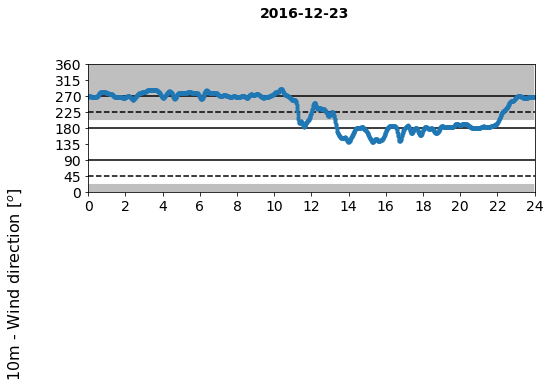

In [11]:
year = '2016'
month = '12'
day = '23'

fig = plt.figure(figsize=(8,8))

fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)

ax1 = fig.add_subplot(311)
ax1.plot(obs_wind_dir_rolling[int(year+month+day)][:,:],'.')
ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(180,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(90,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(45,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')
ax1.hlines(225,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')

ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 202.5, 360,  facecolor='gray', alpha=0.5)
ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 0, 22.5,  facecolor='gray', alpha=0.5)

ax1.set_xlim([0, obs_wind_dir_rolling[int(year+month+day)].shape[0]-1])
ax1.set_ylim([0, 360])
ax1.set_xticks(np.arange(0,obs_wind_dir_rolling[int(year+month+day)].shape[0]+120,120))    
ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
ax1.set_yticks(np.arange(0,405,45))
fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
ax1.tick_params(labelsize=14)
plt.show()

In [12]:
diff_perc_monthly = np.zeros(shape=meps_total.shape)
diff_perc_season = np.zeros(shape=meps_sum.shape)

diff_perc_monthly_east = np.zeros(shape=meps_total_east.shape)
diff_perc_season_east = np.zeros(shape=meps_east_sum.shape)

diff_perc_monthly_west = np.zeros(shape=meps_total_west.shape)
diff_perc_season_west = np.zeros(shape=meps_west_sum.shape)
for ens_memb in range(10):
    diff_perc_monthly[:,ens_memb] = (meps_total[:,ens_memb] - np.array(obs_total))/np.array(obs_total)*100
    diff_perc_season[ens_memb]  = (meps_sum[ens_memb] - sum(obs_total_precip.values()))/sum(obs_total_precip.values())*100
    
    diff_perc_monthly_east[:,ens_memb] = (meps_total_east[:,ens_memb] - np.array(obs_total_east))/np.array(obs_total_east)*100
    diff_perc_season_east[ens_memb]  = (meps_east_sum[ens_memb] - sum(obs_precip_east.values()))/sum(obs_precip_east.values())*100
    
    diff_perc_monthly_west[:,ens_memb] = (meps_total_west[:,ens_memb] - np.array(obs_total_west))/np.array(obs_total_west)*100
    diff_perc_season_west[ens_memb]  = (meps_west_sum[ens_memb] - sum(obs_precip_west.values()))/sum(obs_precip_west.values())*100

In [13]:
### create table

col_labels = ['obs [mm]', 'MEPS [mm]','Difference [%]', ]
row_labels = ['total precipitation', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '', 
              'pulsed - westerly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '',
              'upslope - easterly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017']
#for ens_memb in range(10):
for ens_memb in np.arange(10):
    table_vals = [ ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total[0],2), np.round(meps_total[0,ens_memb],2), np.round(diff_perc_monthly[0,ens_memb],2)],
               [np.round(obs_total[1],2), np.round(meps_total[1,ens_memb],2), np.round(diff_perc_monthly[1,ens_memb],2)],
               [np.round(obs_total[2],2), np.round(meps_total[2,ens_memb],2), np.round(diff_perc_monthly[2,ens_memb],2)],
               [np.round(obs_total[3],2), np.round(meps_total[3,ens_memb],2), np.round(diff_perc_monthly[3,ens_memb],2)],
               [np.round(obs_total[4],2), np.round(meps_total[4,ens_memb],2), np.round(diff_perc_monthly[4,ens_memb],2)],
               [np.round(sum(obs_total_precip.values()),2), np.round(meps_sum[ens_memb],2), np.round(diff_perc_season[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_west[0],2), np.round(meps_total_west[0,ens_memb],2), np.round(diff_perc_monthly_west[0,ens_memb],2)],
               [np.round(obs_total_west[1],2), np.round(meps_total_west[1,ens_memb],2), np.round(diff_perc_monthly_west[1,ens_memb],2)],
               [np.round(obs_total_west[2],2), np.round(meps_total_west[2,ens_memb],2), np.round(diff_perc_monthly_west[2,ens_memb],2)],
               [np.round(obs_total_west[3],2), np.round(meps_total_west[3,ens_memb],2), np.round(diff_perc_monthly_west[3,ens_memb],2)],
               [np.round(obs_total_west[4],2), np.round(meps_total_west[4,ens_memb],2), np.round(diff_perc_monthly_west[4,ens_memb],2)],
               [np.round(sum(obs_precip_west.values()),2), np.round(meps_west_sum[ens_memb],2), np.round(diff_perc_season_west[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_east[0],2), np.round(meps_total_east[0,ens_memb],2), np.round(diff_perc_monthly_east[0,ens_memb],2)],
               [np.round(obs_total_east[1],2), np.round(meps_total_east[1,ens_memb],2), np.round(diff_perc_monthly_east[1,ens_memb],2)],
               [np.round(obs_total_east[2],2), np.round(meps_total_east[2,ens_memb],2), np.round(diff_perc_monthly_east[2,ens_memb],2)],
               [np.round(obs_total_east[3],2), np.round(meps_total_east[3,ens_memb],2), np.round(diff_perc_monthly_east[3,ens_memb],2)],
               [np.round(obs_total_east[4],2), np.round(meps_total_east[4,ens_memb],2), np.round(diff_perc_monthly_east[4,ens_memb],2)],
               [np.round(sum(obs_precip_east.values()),2), np.round(meps_east_sum[ens_memb],2), np.round(diff_perc_season_east[ens_memb],2)]]


# Draw table
    fig = plt.figure()
    ax = fig.add_subplot(111)
    the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    
    yy = 2.83
    fig_name = station+'_winter_16_17_EM'+str(ens_memb)+'.'+form
    ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

    if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()
    
    if ens_memb == 9:
        table_vals = [ ['', 'ensemble mean' , '' ],
               [np.round(obs_total[0],2), np.round(np.mean(meps_total, axis = 1)[0],2), np.round(np.mean(diff_perc_monthly, axis=1)[0],2)],
               [np.round(obs_total[1],2), np.round(np.mean(meps_total, axis = 1)[1],2), np.round(np.mean(diff_perc_monthly, axis=1)[1],2)],
               [np.round(obs_total[2],2), np.round(np.mean(meps_total, axis = 1)[2],2), np.round(np.mean(diff_perc_monthly, axis=1)[2],2)],
               [np.round(obs_total[3],2), np.round(np.mean(meps_total, axis = 1)[3],2), np.round(np.mean(diff_perc_monthly, axis=1)[3],2)],
               [np.round(obs_total[4],2), np.round(np.mean(meps_total, axis = 1)[4],2), np.round(np.mean(diff_perc_monthly, axis=1)[4],2)],
               [np.round(sum(obs_total_precip.values()),2), np.round(np.mean(meps_sum, axis = 0),2), np.round(np.mean(diff_perc_season, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_west[0],2), np.round(np.mean(meps_total_west, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[0],2)],
               [np.round(obs_total_west[1],2), np.round(np.mean(meps_total_west, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[1],2)],
               [np.round(obs_total_west[2],2), np.round(np.mean(meps_total_west, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[2],2)],
               [np.round(obs_total_west[3],2), np.round(np.mean(meps_total_west, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[3],2)],
               [np.round(obs_total_west[4],2), np.round(np.mean(meps_total_west, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[4],2)],
               [np.round(sum(obs_precip_west.values()),2), np.round(np.mean(meps_west_sum, axis = 0),2), np.round(np.mean(diff_perc_season_west, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_east[0],2), np.round(np.mean(meps_total_east, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[0],2)],
               [np.round(obs_total_east[1],2), np.round(np.mean(meps_total_east, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[1],2)],
               [np.round(obs_total_east[2],2), np.round(np.mean(meps_total_east, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[2],2)],
               [np.round(obs_total_east[3],2), np.round(np.mean(meps_total_east, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[3],2)],
               [np.round(obs_total_east[4],2), np.round(np.mean(meps_total_east, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[4],2)],
               [np.round(sum(obs_precip_east.values()),2), np.round(np.mean(meps_east_sum, axis = 0),2), np.round(np.mean(diff_perc_season_east, axis = 0),2)]]
        # Draw table
        fig = plt.figure()
        ax = fig.add_subplot(111)
        the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(24)
        the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        yy = 2.83
        fig_name = station+'_winter_16_17_ensemble_mean'+'.'+form
        ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

        if savefig == 1:
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
            print('plot saved: %s/%s' %(figdir,fig_name))
        else:
            plt.show()
        plt.close()

plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM0.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM1.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM2.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM3.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM4.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM5.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM6.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM7.png
plot saved: ../../Figures/Weathermast_MEPS/Haukeliseter/precip_seasonal_stat/Haukeliseter_winter_16_17_EM8.png
p